# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекc Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('real_estate_data.csv', sep = '\t')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

### Вывод

Исходя из таблицы и информации из результата функции `df.info()` есть следующие проблемы:

1. `first_day_exposition` должен быть в формате datetime, а не object
2. `last_price` нужно переделать в int
3. `ceiling_height` есть пропущенные значения в виде NaN
4. `floors_total` есть пропущенные значения в виде NaN, должен быть тип int
5. `living_area` есть пропущенные значения в виде NaN
6. `is_apartment` много пропущенных значений и должен быть тип bool
7. `kitchen_area` есть пропущенные значения в виде NaN
8. `balcony` есть пропущенные значения в виде NaN, должен быть тип int
9. `locality_name` есть пропущенные значения в виде NaN
10. `airports_nearest` есть пропущенные значения в виде NaN
11. `cityCenters_nearest` есть пропущенные значения в виде NaN
12. `parks_around3000` есть пропущенные значения в виде NaN, должен быть тип int
13. `parks_nearest` есть пропущенные значения в виде NaN, должен быть тип int
14. `ponds_around3000` есть пропущенные значения в виде NaN, должен быть тип int
15. `ponds_nearest` есть пропущенные значения в виде NaN, должен быть тип int
16. `days_exposition` есть пропущенные значения в виде NaN, должен быть тип int

## Предобработка данных

Посмотрим количество пропусков в каждом из столбцов

In [23]:
display(df.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Для наглядности посчитаем долю пропусков в процентах

In [24]:
df.isna().mean()*100 #Доля пропусков в процентах

total_images             0.000000
last_price               0.000000
total_area               0.000000
first_day_exposition     0.000000
rooms                    0.000000
ceiling_height          38.799105
floors_total             0.362885
living_area              8.029875
floor                    0.000000
is_apartment            88.290645
studio                   0.000000
open_plan                0.000000
kitchen_area             9.612220
balcony                 48.605426
locality_name            0.206760
airports_nearest        23.384953
cityCenters_nearest     23.287902
parks_around3000        23.283683
parks_nearest           65.909954
ponds_around3000        23.283683
ponds_nearest           61.559559
days_exposition         13.422507
dtype: float64

Поменяем формат в столбце `first_day_exposition`

In [25]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format = '%Y-%m-%d')

Поменяем формат столбца `last_price` и `days_exposition`, также оставим только те квартиры, которые стояли меньше 25 миллионов рублей, чтобы уменьшить разброс значений цен на квартиры. Заменим пустые значения в `days_exposition` на нули и ограничим 720 днями или 2 годами.

In [26]:
df['last_price'] = df['last_price'].astype('int')
df = df[(df['last_price'] < 25000000) & (df['last_price'] > 1000000)] 
df['days_exposition'] = df['days_exposition'].fillna(0).astype('int')
df = df[df['days_exposition']<=720]
display(df)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.00,2019-03-07,3,2.70,16.0,51.0,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,0
1,7,3350000,40.40,2018-12-04,1,NaN,11.0,18.6,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81
2,10,5196000,56.00,2015-08-20,2,NaN,5.0,34.3,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558
4,2,10000000,100.00,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121
5,10,2890000,30.40,2018-09-10,1,NaN,12.0,14.4,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000,133.81,2017-03-21,3,3.70,5.0,73.3,3,NaN,...,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,0
23695,14,3100000,59.00,2018-01-15,3,NaN,5.0,38.0,4,NaN,...,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45
23696,18,2500000,56.70,2018-02-11,2,NaN,3.0,29.7,1,NaN,...,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,0
23697,13,11475000,76.75,2017-03-28,2,3.00,17.0,NaN,12,NaN,...,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602


Уберем пропущенные значения из столбца `ceiling_height`, а также оставим только те строчки, где высота потолков от 2 до 4 метров.

In [27]:
print(df['ceiling_height'].unique())
med = df['ceiling_height'].median()
df['ceiling_height'] = df['ceiling_height'].fillna(med)
df = df[(df['ceiling_height'] >= 2) & (df['ceiling_height']<=4)]
display(df)

[  2.7     nan   3.03   2.5    2.67   2.56   3.05   2.75   2.6    2.9
   2.8    2.55   2.65   3.     2.61   3.2    3.25   3.45   2.64   2.57
   4.15   3.3    2.71   4.     2.47   2.73   2.84   2.77   2.34   3.4
   3.5    3.06   2.72   2.54   2.51   2.78   2.76   3.1   25.     2.58
   3.7    2.52   2.87   2.66   2.59   2.     2.85   2.45   2.92   3.13
   3.8    3.15   3.6    3.55   3.62   3.12   2.53   2.96   2.46   2.74
   2.79   2.95   4.06   2.94   3.54   3.53   2.83   2.4    3.38   3.01
   3.65   3.18   2.3    2.48   2.62   3.98   2.63   3.83   3.52   3.75
   2.88   3.67   3.87   3.66   4.19   3.95   3.35   3.24   4.8    4.5
   4.2    3.36  32.     3.68   3.07   3.37   3.09   8.     3.16   3.26
   3.34   2.81   3.44   2.97   3.14   4.37   2.68   3.9    3.22   3.27
   2.82  27.     4.1    2.93   3.46  24.     3.47   3.33   3.63   3.11
   3.32  26.     1.2    8.3    2.98   2.86   3.08   3.28   3.04   3.23
   3.02   3.21   3.78   4.3    3.17   3.39   2.69   4.4    3.31   5.3
   3.56   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.00,2019-03-07,3,2.70,16.0,51.0,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,0
1,7,3350000,40.40,2018-12-04,1,2.65,11.0,18.6,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81
2,10,5196000,56.00,2015-08-20,2,2.65,5.0,34.3,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558
4,2,10000000,100.00,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121
5,10,2890000,30.40,2018-09-10,1,2.65,12.0,14.4,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000,133.81,2017-03-21,3,3.70,5.0,73.3,3,NaN,...,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,0
23695,14,3100000,59.00,2018-01-15,3,2.65,5.0,38.0,4,NaN,...,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45
23696,18,2500000,56.70,2018-02-11,2,2.65,3.0,29.7,1,NaN,...,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,0
23697,13,11475000,76.75,2017-03-28,2,3.00,17.0,NaN,12,NaN,...,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602


В столбце `is_apartment` очень много пропусков, которые, возможно, связаны с тем, что люди просто не заполняли данную информацию. Поэтому можем их заменить на False

In [28]:
df['is_apartment'] = df['is_apartment'].fillna(False)
df['is_apartment'].value_counts()

False    22121
True        37
Name: is_apartment, dtype: int64

Заменим пустые значения столбца `kitchen_area` на медианные и проверим как поменяется среднее методом describe(). Как мы видим в выполненном коде ниже, значение уменьшилось совсем не намного.

In [29]:
print(df['kitchen_area'].describe())
med_kitch = df['kitchen_area'].median()
df['kitchen_area'] = df['kitchen_area'].fillna(med_kitch)
df['kitchen_area'].describe()

count    20044.000000
mean        10.217317
std          4.952189
min          1.300000
25%          7.000000
50%          9.000000
75%         11.700000
max        100.700000
Name: kitchen_area, dtype: float64


count    22158.000000
mean        10.101178
std          4.723581
min          1.300000
25%          7.200000
50%          9.000000
75%         11.100000
max        100.700000
Name: kitchen_area, dtype: float64

В столбце `balcony` очень много пропусков, скорее всего, вместо них должны стоять нули, так как люди просто забыли указать что балкона нет.

In [30]:
print(df['balcony'].value_counts())
df['balcony'] = df['balcony'].fillna(0).astype('int')
print(df['balcony'].value_counts())

1.0    3928
0.0    3541
2.0    3496
5.0     289
4.0     163
3.0      75
Name: balcony, dtype: int64
0    14207
1     3928
2     3496
5      289
4      163
3       75
Name: balcony, dtype: int64


Также можем убрать строчки с квартирами количество комнат в которых превышает 7, чтобы уменьшить слишком большие значения по этому столбцу. 

In [31]:
df = df[df['rooms'] <=7]
df['rooms'].value_counts()

1    7707
2    7537
3    5394
4     997
5     225
0     190
6      67
7      28
Name: rooms, dtype: int64

#### Вывод

Проведена предобработка данных. Были затронуты следующие столбцы:
1. `first_day_exposition`
2. `last_price`
3. `days_exposition`
4. `ceiling_height`
5. `is_apartment`
6. `kitchen_area`
7. `balcony`
8. `rooms`

В `last_price` , `ceiling_height` , `rooms` , `days_exposition` мы убрали строки с выбивающимися значениями, чтобы не исказить анализ данных, гистограммы и графики.

Также заполнели пропуски в остальных столбцах и поменяли формат на подходящий для конкретных данных.

## Расчёты и добавление результатов в таблицу

##### Цена квадратного метра

In [32]:
df['price_per_square'] = df['last_price'] / df['total_area'] 
df['price_per_square'] = df['price_per_square'].astype('int')
df.info()
display(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22145 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22145 non-null  int64         
 1   last_price            22145 non-null  int32         
 2   total_area            22145 non-null  float64       
 3   first_day_exposition  22145 non-null  datetime64[ns]
 4   rooms                 22145 non-null  int64         
 5   ceiling_height        22145 non-null  float64       
 6   floors_total          22064 non-null  float64       
 7   living_area           20399 non-null  float64       
 8   floor                 22145 non-null  int64         
 9   is_apartment          22145 non-null  bool          
 10  studio                22145 non-null  bool          
 11  open_plan             22145 non-null  bool          
 12  kitchen_area          22145 non-null  float64       
 13  balcony         

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square
0,20,13000000,108.00,2019-03-07,3,2.70,16.0,51.0,8,False,...,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,0,120370
1,7,3350000,40.40,2018-12-04,1,2.65,11.0,18.6,1,False,...,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81,82920
2,10,5196000,56.00,2015-08-20,2,2.65,5.0,34.3,4,False,...,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558,92785
4,2,10000000,100.00,2018-06-19,2,3.03,14.0,32.0,13,False,...,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121,100000
5,10,2890000,30.40,2018-09-10,1,2.65,12.0,14.4,5,False,...,0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55,95065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000,133.81,2017-03-21,3,3.70,5.0,73.3,3,False,...,0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,0,72490
23695,14,3100000,59.00,2018-01-15,3,2.65,5.0,38.0,4,False,...,0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45,52542
23696,18,2500000,56.70,2018-02-11,2,2.65,3.0,29.7,1,False,...,0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,0,44091
23697,13,11475000,76.75,2017-03-28,2,3.00,17.0,NaN,12,False,...,2,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602,149511


##### День недели, месяц и год публикации объявления

In [33]:
df['weekday_exposition'] = df['first_day_exposition'].dt.weekday
df['month_exposition'] = df['first_day_exposition'].dt.month
df['year_exposition'] = df['first_day_exposition'].dt.year
display(df)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square,weekday_exposition,month_exposition,year_exposition
0,20,13000000,108.00,2019-03-07,3,2.70,16.0,51.0,8,False,...,16028.0,1.0,482.0,2.0,755.0,0,120370,3,3,2019
1,7,3350000,40.40,2018-12-04,1,2.65,11.0,18.6,1,False,...,18603.0,0.0,NaN,0.0,NaN,81,82920,1,12,2018
2,10,5196000,56.00,2015-08-20,2,2.65,5.0,34.3,4,False,...,13933.0,1.0,90.0,2.0,574.0,558,92785,3,8,2015
4,2,10000000,100.00,2018-06-19,2,3.03,14.0,32.0,13,False,...,8098.0,2.0,112.0,1.0,48.0,121,100000,1,6,2018
5,10,2890000,30.40,2018-09-10,1,2.65,12.0,14.4,5,False,...,NaN,NaN,NaN,NaN,NaN,55,95065,0,9,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000,133.81,2017-03-21,3,3.70,5.0,73.3,3,False,...,4232.0,1.0,796.0,3.0,381.0,0,72490,1,3,2017
23695,14,3100000,59.00,2018-01-15,3,2.65,5.0,38.0,4,False,...,NaN,NaN,NaN,NaN,NaN,45,52542,0,1,2018
23696,18,2500000,56.70,2018-02-11,2,2.65,3.0,29.7,1,False,...,NaN,NaN,NaN,NaN,NaN,0,44091,6,2,2018
23697,13,11475000,76.75,2017-03-28,2,3.00,17.0,NaN,12,False,...,10364.0,2.0,173.0,3.0,196.0,602,149511,1,3,2017


##### Этаж квартиры; варианты — первый, последний, другой

In [34]:
#Функция определяющая тип этажа 
def floor_category(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    elif floor > 1 & floor < floors_total:
        return 'другой'
df['floor_category'] = df.apply(floor_category, axis = 1)    
display(df)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square,weekday_exposition,month_exposition,year_exposition,floor_category
0,20,13000000,108.00,2019-03-07,3,2.70,16.0,51.0,8,False,...,1.0,482.0,2.0,755.0,0,120370,3,3,2019,другой
1,7,3350000,40.40,2018-12-04,1,2.65,11.0,18.6,1,False,...,0.0,NaN,0.0,NaN,81,82920,1,12,2018,первый
2,10,5196000,56.00,2015-08-20,2,2.65,5.0,34.3,4,False,...,1.0,90.0,2.0,574.0,558,92785,3,8,2015,другой
4,2,10000000,100.00,2018-06-19,2,3.03,14.0,32.0,13,False,...,2.0,112.0,1.0,48.0,121,100000,1,6,2018,другой
5,10,2890000,30.40,2018-09-10,1,2.65,12.0,14.4,5,False,...,NaN,NaN,NaN,NaN,55,95065,0,9,2018,другой
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000,133.81,2017-03-21,3,3.70,5.0,73.3,3,False,...,1.0,796.0,3.0,381.0,0,72490,1,3,2017,другой
23695,14,3100000,59.00,2018-01-15,3,2.65,5.0,38.0,4,False,...,NaN,NaN,NaN,NaN,45,52542,0,1,2018,другой
23696,18,2500000,56.70,2018-02-11,2,2.65,3.0,29.7,1,False,...,NaN,NaN,NaN,NaN,0,44091,6,2,2018,первый
23697,13,11475000,76.75,2017-03-28,2,3.00,17.0,NaN,12,False,...,2.0,173.0,3.0,196.0,602,149511,1,3,2017,другой


##### Соотношение жилой и общей площади, а также отношение площади кухни к общей

In [35]:
df['living_area_ratio'] = df['living_area'] / df['total_area']
df['kitchen_area_ratio'] = df['kitchen_area'] / df['total_area']
display(df)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_square,weekday_exposition,month_exposition,year_exposition,floor_category,living_area_ratio,kitchen_area_ratio
0,20,13000000,108.00,2019-03-07,3,2.70,16.0,51.0,8,False,...,2.0,755.0,0,120370,3,3,2019,другой,0.472222,0.231481
1,7,3350000,40.40,2018-12-04,1,2.65,11.0,18.6,1,False,...,0.0,NaN,81,82920,1,12,2018,первый,0.460396,0.272277
2,10,5196000,56.00,2015-08-20,2,2.65,5.0,34.3,4,False,...,2.0,574.0,558,92785,3,8,2015,другой,0.612500,0.148214
4,2,10000000,100.00,2018-06-19,2,3.03,14.0,32.0,13,False,...,1.0,48.0,121,100000,1,6,2018,другой,0.320000,0.410000
5,10,2890000,30.40,2018-09-10,1,2.65,12.0,14.4,5,False,...,NaN,NaN,55,95065,0,9,2018,другой,0.473684,0.299342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000,133.81,2017-03-21,3,3.70,5.0,73.3,3,False,...,3.0,381.0,0,72490,1,3,2017,другой,0.547792,0.103356
23695,14,3100000,59.00,2018-01-15,3,2.65,5.0,38.0,4,False,...,NaN,NaN,45,52542,0,1,2018,другой,0.644068,0.144068
23696,18,2500000,56.70,2018-02-11,2,2.65,3.0,29.7,1,False,...,NaN,NaN,0,44091,6,2,2018,первый,0.523810,0.158730
23697,13,11475000,76.75,2017-03-28,2,3.00,17.0,NaN,12,False,...,3.0,196.0,602,149511,1,3,2017,другой,NaN,0.303583


## Исследовательский анализ данных

##### Изучите следующие параметры: площадь, цена, число комнат, высота потолков. Постройте гистограммы для каждого параметра.

count    22145.000000
mean        57.238589
std         25.738617
min         12.000000
25%         40.000000
50%         51.000000
75%         67.700000
max        460.800000
Name: total_area, dtype: float64


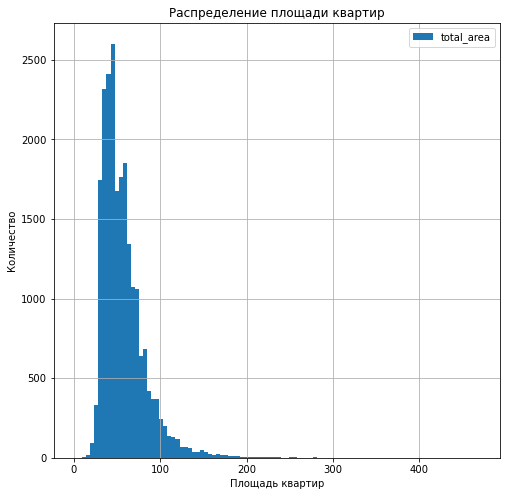

In [36]:
print(df['total_area'].describe())
df.plot(y='total_area', kind='hist', bins=100, range=(0,470), grid=True, figsize=(8,8));
plt.title('Распределение площади квартир');
plt.xlabel('Площадь квартир');
plt.ylabel('Количество');

Основные значения находятся в диапозоне от 40 до 80. Есть конечно единичные случаи очень больших значений по типу 460 квардратных метро, но на исследования они не сильно влияют.

Для удобства сделаю столбцев, где цена будет записана в миллионах рублей.

count    22145.000000
mean         5.581341
std          3.524355
min          1.010000
25%          3.420000
50%          4.600000
75%          6.500000
max         24.900000
Name: total_price, dtype: float64


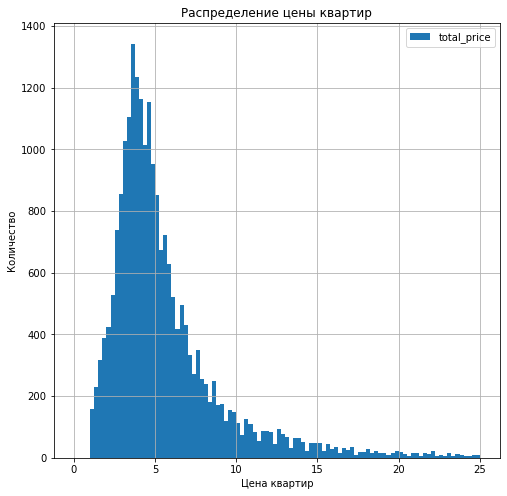

In [37]:
df['total_price'] = df['last_price'] / 1000000
#display(df)
print(df['total_price'].describe())
df.plot(y='total_price', kind='hist', bins=100, range=(0,25), grid=True, figsize=(8,8))
plt.title('Распределение цены квартир');
plt.xlabel('Цена квартир');
plt.ylabel('Количество');

Больших значений не так много, большая часть находится в районе 4 миллионов, поэтому не сильно влияет не исследование.

count    22145.000000
mean         2.017340
std          0.988539
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64


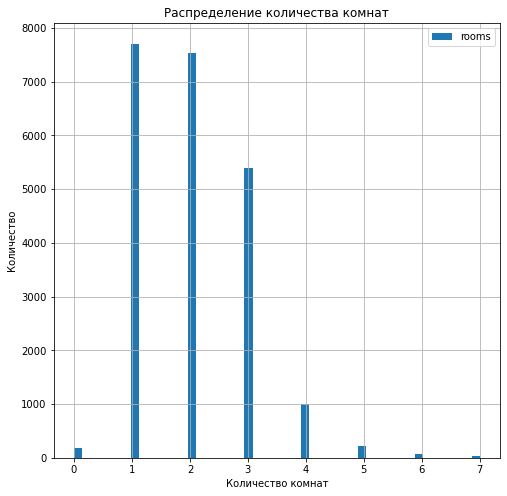

In [38]:
print(df['rooms'].describe())
df.plot(y='rooms', kind='hist', bins=50, grid=True, figsize=(8,8))
plt.title('Распределение количества комнат');
plt.xlabel('Количество комнат');
plt.ylabel('Количество');

В основном 1,2 или 3-х комнатные квартиры. Есть конечно и 7 комнатные квартиры, но на исследование они не повлияют.

count    22145.000000
mean         2.685860
std          0.193775
min          2.000000
25%          2.600000
50%          2.650000
75%          2.700000
max          4.000000
Name: ceiling_height, dtype: float64


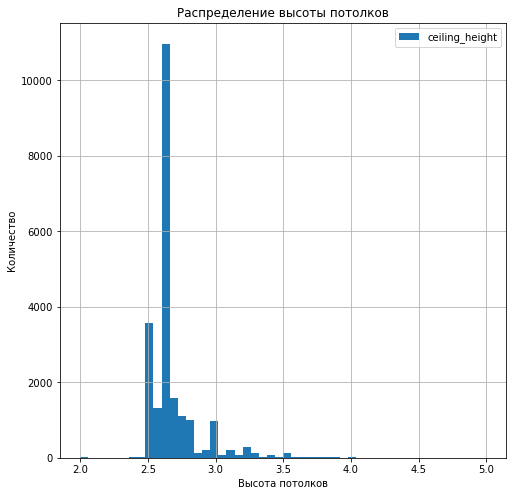

In [39]:
print(df['ceiling_height'].describe())
df.plot(y='ceiling_height', kind='hist', bins=50, range=(2,5), grid=True, figsize = (8,8))
plt.title('Распределение высоты потолков');
plt.xlabel('Высота потолков');
plt.ylabel('Количество');

В основном все значения находится от 2 до 3 метров, а от аномальных значений мы избавились еще в предобработке данных.

##### Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

count    19162.000000
mean       148.673625
std        153.609026
min          1.000000
25%         43.000000
50%         90.000000
75%        203.000000
max        720.000000
Name: days_exposition, dtype: float64
45     841
60     537
7      230
30     204
90     184
      ... 
572      1
693      1
1        1
651      1
712      1
Name: days_exposition, Length: 712, dtype: int64


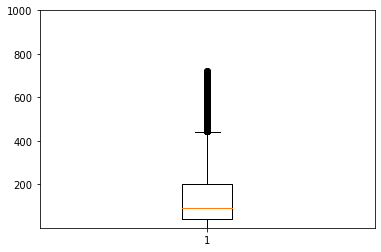

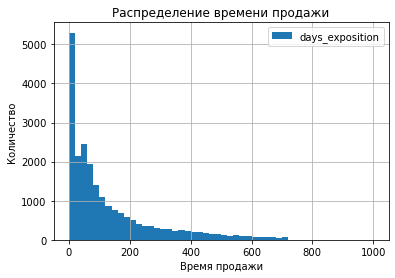

In [40]:
plt.boxplot(df[df['days_exposition']!=0]['days_exposition'])
plt.ylim(1,1000)
print(df[df['days_exposition']!=0]['days_exposition'].describe())
print(df[df['days_exposition']!=0]['days_exposition'].value_counts())
df.plot(y='days_exposition', kind='hist', bins=50, range=(0,1000), grid=True)
plt.title('Распределение времени продажи');
plt.xlabel('Время продажи');
plt.ylabel('Количество');

Видим, что многие объявления были сняты с продажи через 7,30,45,60 и 90 дней. Я думаю, что это связано с особенностями платформы, которая автоматически может убирать объявления через кокнернтое количество дней.
Среднее равно 148, а медиана 90.
Выбросы начинаются после значения в 450 дней по ящику с усами, это может говорить о чрезвычайно долгих продажах, которые длились больше 450 дней.

##### Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили.

Изначально не увидел, что будет такой блок, но я провел всю эту работу в изучении данных из файла, так как для построения гистограмм нужны были уже готовые данные для исследования, которые не будут искажать результаты. Я убрал квартиры с количеством комнат больше 7 и стоимостью более 25 миллионов. Также ограничил количество дней объявления до 2 лет и высоту потолков от 2 до 4 метров. Результаты исследования не исказятся из-за того, что мы уберем данные строчки.

##### Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от площади, числа комнат, удалённости от центра. Изучите зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также изучите зависимость от даты размещения: дня недели, месяца и года.

0.7822677623760523


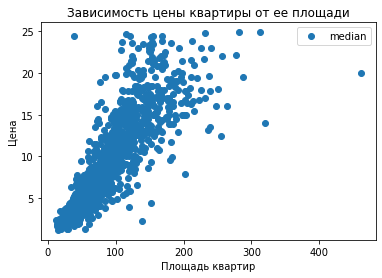

In [41]:
total_area_price = df.pivot_table(index = 'total_area', values = 'total_price' , aggfunc=['mean', 'count', 'median'])
total_area_price.columns = ['mean', 'count', 'median']
total_area_price.plot(y = 'median', style = 'o')
plt.title('Зависимость цены квартиры от ее площади');
plt.xlabel('Площадь квартир');
plt.ylabel('Цена');
print(df['total_area'].corr(df['total_price']))

Корреляция равна 0.65, что довольно логично, ведь цена квартиры зависит от ее площади. 

,mean,count,median
rooms,,,
0,2.989610,190,2.715
1,3.837107,7707,3.600
2,5.431947,7537,4.790
3,7.184230,5394,6.100
4,9.572386,997,8.400
5,12.009038,225,11.999
6,15.356385,67,14.500
7,17.546071,28,16.700


0.5141392023858361

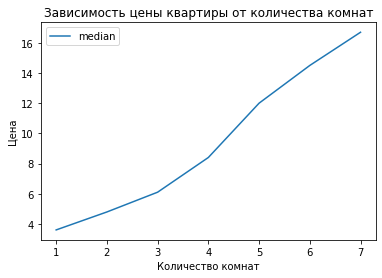

In [42]:
rooms_price = df.pivot_table(index = 'rooms', values = 'total_price', aggfunc = ['mean', 'count', 'median'])
rooms_price.columns = ['mean', 'count', 'median']
display(rooms_price)
rooms_price.query('count > 20 and rooms > 0').plot(y = 'median')
plt.title('Зависимость цены квартиры от количества комнат');
plt.xlabel('Количество комнат');
plt.ylabel('Цена');
df['rooms'].corr(df['total_price'])

Как мы видим, самая маленькая стоимость у однокомнатных квартир, а самая высокая у семикомнатных.

-0.34739186218526186

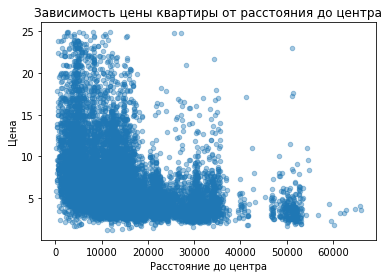

In [43]:
df.plot(y='total_price', x='cityCenters_nearest', kind='scatter', alpha=0.4)
plt.title('Зависимость цены квартиры от расстояния до центра');
plt.xlabel('Расстояние до центра');
plt.ylabel('Цена');
df['cityCenters_nearest'].corr(df['total_price'])

Видим резкий скачок в районе 6-7 км от центра, то есть зависимость все-таки есть о чем и говорит корреляция. Значит чем ближе к центру, тем стоимость квартиры выше.

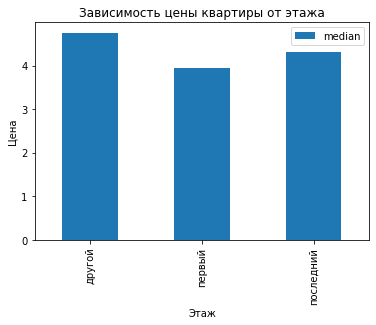

In [44]:
floor_category_price = df.pivot_table(index='floor_category', values = 'total_price', aggfunc = ['mean', 'count', 'median'])
floor_category_price.columns = ['mean', 'count', 'median']
floor_category_price.plot(y = 'median', kind='bar')
plt.title('Зависимость цены квартиры от этажа');
plt.xlabel('Этаж');
plt.ylabel('Цена');

Самая низкая стоимость у первого этажа, дальше по стоимости последний этаж и этажи из категории другой имеет самую высокую стоимость

,mean,count,median
weekday_exposition,,,
5,5.443642,1800,4.500
6,5.436884,1594,4.500
4,5.533386,3777,4.550
3,5.669621,3995,4.595
0,5.564547,3383,4.600
1,5.594819,3903,4.650
2,5.665495,3693,4.650


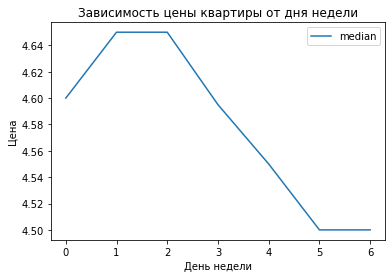

In [61]:
weekday_exposition_price = df.pivot_table(index = 'weekday_exposition', values = 'total_price', aggfunc = ['mean', 'count', 'median'])
weekday_exposition_price.columns = ['mean', 'count', 'median']
weekday_exposition_price.plot(y = 'median');
plt.title('Зависимость цены квартиры от дня недели');
plt.xlabel('День недели');
plt.ylabel('Цена');
weekday_exposition_price.sort_values('median')

Самая высокая стоимость квартир во вторник, затем она падает до пятница и остается неизменной до воскресенья

,mean,count,median
month_exposition,,,
6,5.373590,1636,4.370000
5,5.568092,1188,4.500000
8,5.495757,1645,4.500000
10,5.501472,2018,4.526000
1,5.647183,1399,4.600000
2,5.631716,2472,4.600000
3,5.565013,2387,4.600000
7,5.594516,1578,4.600000
9,5.701830,1846,4.600000


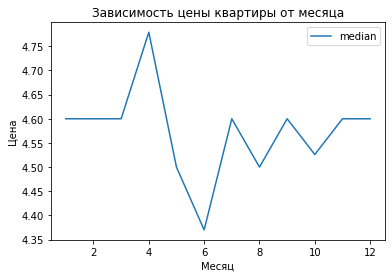

In [62]:
month_exposition_price = df.pivot_table(index = 'month_exposition', values = 'total_price', aggfunc = ['mean', 'count', 'median'])
month_exposition_price.columns = ['mean', 'count', 'median']
month_exposition_price.plot(y = 'median');
plt.title('Зависимость цены квартиры от месяца');
plt.xlabel('Месяц');
plt.ylabel('Цена');
month_exposition_price.sort_values('median')

Самые высокие цены в апреле, сентябре и ноября. А самая низкая цена в июне. С апреля по июнь происходит резкое падение цен на квартиры 

,mean,count,median
year_exposition,,,
2016,5.539072,2422,4.450
2017,5.497836,7895,4.499
2018,5.470394,8260,4.550
2015,6.262921,737,5.000
2019,5.931649,2777,5.000
2014,9.339447,54,7.640


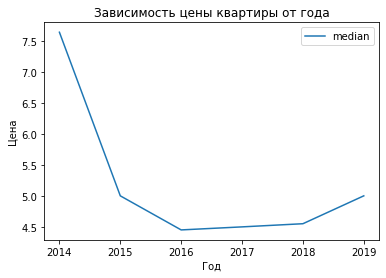

In [63]:
year_exposition_price = df.pivot_table(index = 'year_exposition', values = 'total_price', aggfunc = ['mean', 'count', 'median'])
year_exposition_price.columns = ['mean', 'count', 'median']
year_exposition_price.plot(y = 'median');
plt.title('Зависимость цены квартиры от года');
plt.xlabel('Год');
plt.ylabel('Цена');
year_exposition_price.sort_values('median')

До 2016 года цена стабильно падала, а затем начала рости до 2019 года

##### Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите среди них населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце `locality_name`.

In [48]:
locality_price = df.pivot_table(index = 'locality_name', values = 'total_price', aggfunc = ['count', 'mean'])
locality_price.columns = ['count', 'mean']
locality_price = locality_price.sort_values('count', ascending = False).head(10)
display(locality_price)
display(locality_price[locality_price['mean'] == locality_price['mean'].max()])
display(locality_price[locality_price['mean'] == locality_price['mean'].min()])

,count,mean
locality_name,,
Санкт-Петербург,14671,6.594575
посёлок Мурино,502,3.652240
посёлок Шушары,428,4.114993
Всеволожск,383,3.819773
Пушкин,347,5.981615
Колпино,331,3.851149
посёлок Парголово,320,4.496317
Гатчина,291,3.500596
деревня Кудрово,280,4.254073


,count,mean
locality_name,,
Санкт-Петербург,14671,6.594575


,count,mean
locality_name,,
Выборг,224,3.270013


Самые дорогие квартиры в Санкт-Петербурге, а самые дешевые в Выборге

##### Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге `(locality_name)`. Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется, — это и будет центральная зона.

,total_price
cityCenters_nearest_km,
0,10.412593
1,10.715237
2,10.340178
3,9.368883
4,10.306970
5,9.309796
6,8.712403
7,8.383280
8,7.793580


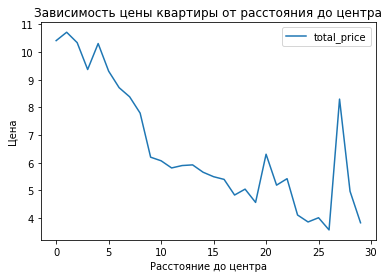

In [64]:
df['cityCenters_nearest_km'] = df['cityCenters_nearest'] / 1000
df['cityCenters_nearest_km'] = df['cityCenters_nearest_km'].fillna(100000)
df['cityCenters_nearest_km'] = df['cityCenters_nearest_km'].astype('int')
pivot_table_km = df.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km !=100000').pivot_table(index = 'cityCenters_nearest_km', values = 'total_price', aggfunc='mean')
pivot_table_km.plot();
plt.title('Зависимость цены квартиры от расстояния до центра');
plt.xlabel('Расстояние до центра');
plt.ylabel('Цена');
display(pivot_table_km)

Судя по графику и таблице центром можно считать диапозон от 5-10 км, потому что после 10 километра цена сильно падает и не превосходит предыдущих.

##### Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всей базе?

In [50]:
spb_df = df.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km <= 10')
display(spb_df)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,price_per_square,weekday_exposition,month_exposition,year_exposition,floor_category,living_area_ratio,kitchen_area_ratio,total_price,cityCenters_nearest_km
4,2,10000000,100.00,2018-06-19,2,3.03,14.0,32.0,13,False,...,121,100000,1,6,2018,другой,0.320000,0.410000,10.000,8
16,11,6700000,82.00,2017-11-23,3,3.05,5.0,55.6,1,False,...,397,81707,3,11,2017,первый,0.678049,0.109756,6.700,10
18,8,3250000,31.00,2017-01-27,1,2.50,5.0,19.4,2,False,...,168,104838,4,1,2017,другой,0.625806,0.180645,3.250,10
21,13,3200000,31.60,2018-03-14,1,2.65,5.0,16.9,2,False,...,310,101265,2,3,2018,другой,0.534810,0.180380,3.200,9
24,8,6500000,97.20,2015-10-31,2,2.65,3.0,46.5,1,False,...,265,66872,5,10,2015,первый,0.478395,0.201646,6.500,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23681,13,5250000,43.00,2018-05-11,2,2.50,5.0,29.0,2,False,...,80,122093,4,5,2018,другой,0.674419,0.139535,5.250,7
23690,3,5500000,52.00,2018-07-19,2,2.65,5.0,31.0,2,False,...,15,105769,3,7,2018,другой,0.596154,0.115385,5.500,6
23691,11,9470000,72.90,2016-10-13,2,2.75,25.0,40.3,7,False,...,519,129903,3,10,2016,другой,0.552812,0.145405,9.470,4
23694,9,9700000,133.81,2017-03-21,3,3.70,5.0,73.3,3,False,...,0,72490,1,3,2017,другой,0.547792,0.103356,9.700,4


Создали новый датафрейм, чтобы выделить квартиры в центре Санкт-Петербурга

##### Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. 

count    5218.000000
mean       70.143660
std        33.622745
min        12.000000
25%        45.000000
50%        62.600000
75%        86.000000
max       287.500000
Name: total_area, dtype: float64


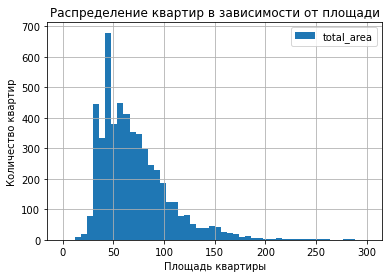

In [68]:
print(spb_df['total_area'].describe())
spb_df.plot(y='total_area', kind='hist', bins=50, range=(0,300), grid=True)
plt.title('Распределение квартир в зависимости от площади');
plt.xlabel('Площадь квартиры');
plt.ylabel('Количество квартир');

Как мы видим, в центре Санкт_Петербурга основная часть квартир 30 до 80 квадратных метров.

count    5218.000000
mean        8.353392
std         4.553799
min         1.600000
25%         4.999250
50%         7.000000
75%        10.500000
max        24.900000
Name: total_price, dtype: float64


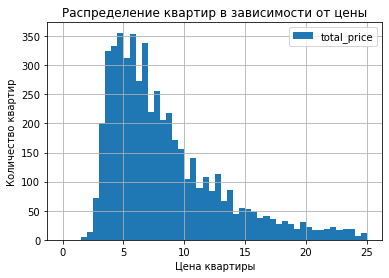

In [69]:
print(spb_df['total_price'].describe())
spb_df.plot(y='total_price', kind='hist', bins=50, range=(0,25), grid=True)
plt.title('Распределение квартир в зависимости от цены');
plt.xlabel('Цена квартиры');
plt.ylabel('Количество квартир');

Большая часть квартир стоит в диапозоне от 3 до 8 миллионов. Есть и большие значения от 20 миллионов и выше.

count    5218.000000
mean        2.371215
std         1.138313
min         0.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         7.000000
Name: rooms, dtype: float64


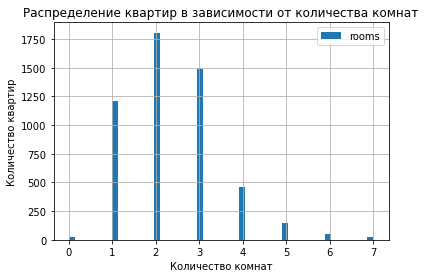

In [70]:
print(spb_df['rooms'].describe())
spb_df.plot(y='rooms', kind='hist', bins=50, range=(0,7), grid=True)
plt.title('Распределение квартир в зависимости от количества комнат');
plt.xlabel('Количество комнат');
plt.ylabel('Количество квартир');

Больше всего в центре Санкт-Петербурга двухкомнатных квартир, далее трехкомнатные и однокомнатные.Также присутствуют квартиры с большим количеством комнат.

count    5218.000000
mean        2.817118
std         0.291934
min         2.000000
25%         2.650000
50%         2.650000
75%         3.000000
max         4.000000
Name: ceiling_height, dtype: float64


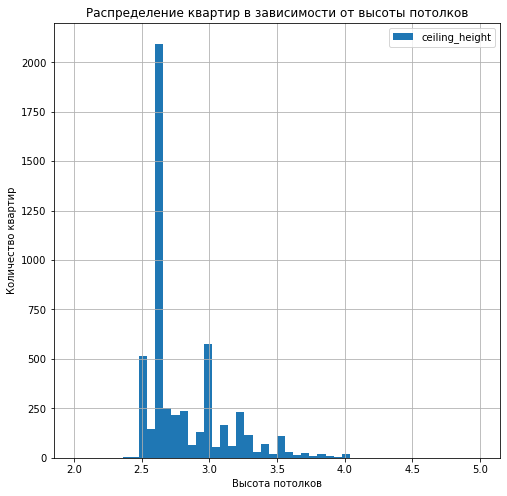

In [71]:
print(spb_df['ceiling_height'].describe())
spb_df.plot(y='ceiling_height', kind='hist', bins=50, range=(2,5), grid=True, figsize = (8,8))
plt.title('Распределение квартир в зависимости от высоты потолков');
plt.xlabel('Высота потолков');
plt.ylabel('Количество квартир');

Основная часть квартир имеет высоту потолков около 2.6-2.7 метров, но есть и квартиры с высотой потолков больше 3 метров.

##### Вывод

Площадь типового объекта центра Санкт-Петебурга не сильно отличается от типового объекта всей базы данных. Тоже самое происходит и с ценой, большая часть значений находится около 4 миллионов рублей. В общей базе преобладают однокомнатные квартиры, а в центре Санкт-Петербурга в основном двухкомнатные. Гистограммы высоты потолков совпадают.

##### Влияние числа комнат на стоимость квартиры

0.5428003700479866

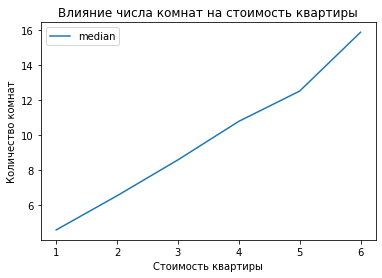

In [72]:
spb_rooms_price = spb_df.pivot_table(index = 'rooms', values = 'total_price', aggfunc = ['count', 'mean', 'median'])
spb_rooms_price.columns = ['count', 'mean', 'median']
spb_rooms_price.query('count > 50 and rooms > 0').plot(y = 'median')
plt.title('Влияние числа комнат на стоимость квартиры');
plt.xlabel('Стоимость квартиры');
plt.ylabel('Количество комнат');
spb_df['rooms'].corr(spb_df['total_price'])

Как мы можем видеть небольшая корреляция все-таки имеется, поэтому чем больше комнат, тем больше цена квартиры.

##### Влияние этажа на стоимость квартиры

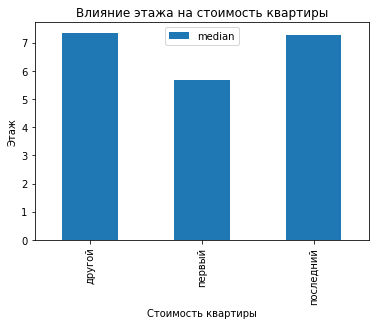

In [73]:
spb_floor_category_price = spb_df.pivot_table(index='floor_category', values = 'total_price', aggfunc = ['mean', 'count', 'median'])
spb_floor_category_price.columns = ['mean', 'count', 'median']
spb_floor_category_price.plot(y = 'median', kind='bar')
plt.title('Влияние этажа на стоимость квартиры');
plt.xlabel('Стоимость квартиры');
plt.ylabel('Этаж');

Здесь мы можем видеть отличие от анализа общего датафрейма, там последний стоил меньше чем квартиры из категории другой, но здесь последний стоит дороже всех.

##### Влияние расстояния от центра на стоимость квартиры

-0.34406529128074503


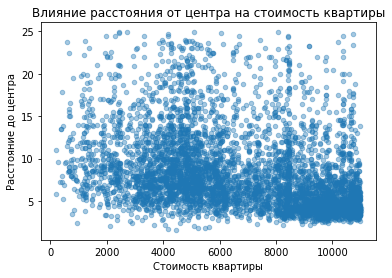

In [74]:
print(spb_df['cityCenters_nearest'].corr(spb_df['total_price']))
spb_df.plot(y = 'total_price', x = 'cityCenters_nearest', kind = 'scatter', alpha = 0.4)
plt.title('Влияние расстояния от центра на стоимость квартиры');
plt.xlabel('Стоимость квартиры');
plt.ylabel('Расстояние до центра');

Корреляция очень низкая, поэтому прямая зависимость отсутствует.

##### Влияние даты размещения на стоимость квартиры

,mean,count,median
weekday_exposition,,,
5,5.443642,1800,4.500
6,5.436884,1594,4.500
4,5.533386,3777,4.550
3,5.669621,3995,4.595
0,5.564547,3383,4.600
1,5.594819,3903,4.650
2,5.665495,3693,4.650


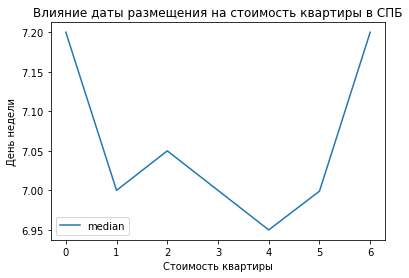

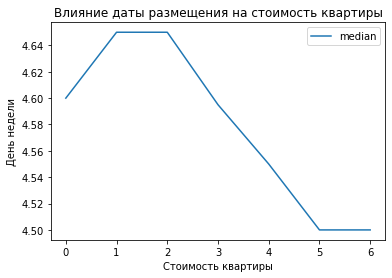

In [75]:
spb_weekday_exposition_price = spb_df.pivot_table(index = 'weekday_exposition', values = 'total_price', aggfunc = ['mean', 'count', 'median'])
spb_weekday_exposition_price.columns = ['mean', 'count', 'median']
spb_weekday_exposition_price.plot(y = 'median')
plt.title('Влияние даты размещения на стоимость квартиры в СПБ');
plt.xlabel('Стоимость квартиры');
plt.ylabel('День недели');
spb_weekday_exposition_price.sort_values('median')
#общий датафрейм
weekday_exposition_price = df.pivot_table(index = 'weekday_exposition', values = 'total_price', aggfunc = ['mean', 'count', 'median'])
weekday_exposition_price.columns = ['mean', 'count', 'median']
weekday_exposition_price.plot(y = 'median')
plt.title('Влияние даты размещения на стоимость квартиры');
plt.xlabel('Стоимость квартиры');
plt.ylabel('День недели');
weekday_exposition_price.sort_values('median')

Как мы видим пик стоимости в понедельник и воскресенье, а самая низкая цена в пятницу. График в Санкт-Петербурге довольно сильно отличается от графика общей выборки.

,mean,count,median
month_exposition,,,
6,5.373590,1636,4.370000
5,5.568092,1188,4.500000
8,5.495757,1645,4.500000
10,5.501472,2018,4.526000
1,5.647183,1399,4.600000
2,5.631716,2472,4.600000
3,5.565013,2387,4.600000
7,5.594516,1578,4.600000
9,5.701830,1846,4.600000


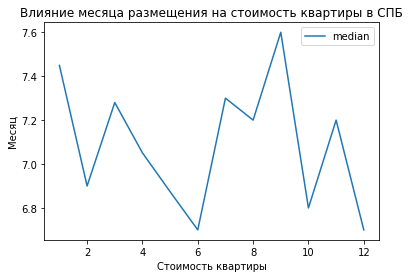

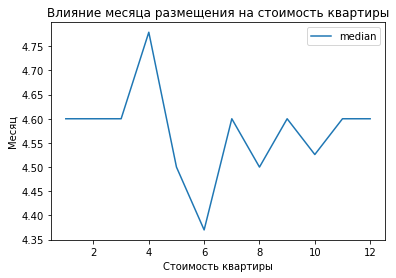

In [76]:
spb_month_exposition_price = spb_df.pivot_table(index = 'month_exposition', values = 'total_price', aggfunc = ['mean', 'count', 'median'])
spb_month_exposition_price.columns = ['mean', 'count', 'median']
spb_month_exposition_price.plot(y = 'median')
plt.title('Влияние месяца размещения на стоимость квартиры в СПБ');
plt.xlabel('Стоимость квартиры');
plt.ylabel('Месяц');
spb_month_exposition_price.sort_values('median')
#Общий датафрейм
month_exposition_price = df.pivot_table(index = 'month_exposition', values = 'total_price', aggfunc = ['mean', 'count', 'median'])
month_exposition_price.columns = ['mean', 'count', 'median']
month_exposition_price.plot(y = 'median')
plt.title('Влияние месяца размещения на стоимость квартиры');
plt.xlabel('Стоимость квартиры');
plt.ylabel('Месяц');
month_exposition_price.sort_values('median')

Графики немного похожи, но все же есть некоторые отличия. В июне самеы низкие цены, а самые высокие в апреле, после которого идет сильное снижение.

,mean,count,median
year_exposition,,,
2016,5.539072,2422,4.450
2017,5.497836,7895,4.499
2018,5.470394,8260,4.550
2015,6.262921,737,5.000
2019,5.931649,2777,5.000
2014,9.339447,54,7.640


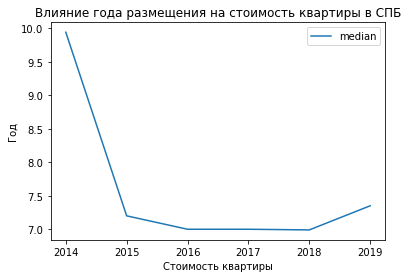

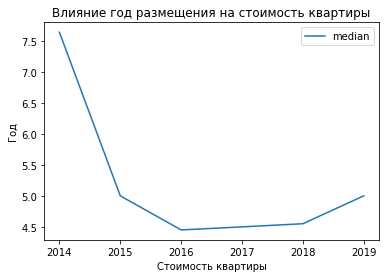

In [77]:
spb_year_exposition_price = spb_df.pivot_table(index = 'year_exposition', values = 'total_price', aggfunc = ['mean', 'count', 'median'])
spb_year_exposition_price.columns = ['mean', 'count', 'median']
spb_year_exposition_price.plot(y = 'median')
plt.title('Влияние года размещения на стоимость квартиры в СПБ');
plt.xlabel('Стоимость квартиры');
plt.ylabel('Год');
spb_year_exposition_price.sort_values('median')
#Общий датафрейм
year_exposition_price = df.pivot_table(index = 'year_exposition', values = 'total_price', aggfunc = ['mean', 'count', 'median'])
year_exposition_price.columns = ['mean', 'count', 'median']
year_exposition_price.plot(y = 'median')
plt.title('Влияние год размещения на стоимость квартиры');
plt.xlabel('Стоимость квартиры');
plt.ylabel('Год');
year_exposition_price.sort_values('median')

С 2014 по 2015 год идет больший спад, нежели в общим датафрейме. с 2016 года по 2018 цена незначительно снизилась, но затем с 2018 года сильно увеличивалась. График немного похож на графи кобщего датафрейма.

## Общий вывод

Была проведена предобработка данных, при которой были выявлены недочеты и аномалии в данных датафрейма. Удалили строки, которые могли искажать графики и гистограммы, а также плохо повлиять на исследование в целом. Некоторые столбцы остались нетронутыми, так как они не участвовали в исследовании.

Столбцы, которые подверглись изменениям:
1. Количество комнат не больше 7
2. Стоимость квартир не больше 25 миллионов
3. Высота потолков от 2 до 4 метров
4. количество дней объявления не больше 720

##### Зависимость
1. Сильная зависимость стоимости квартир от площади, что довольно логично.
2. Сильная зависимость стоимости квартир от количество комнат, чем их больше, тем выше цена.
3. Чем ближе к центру, тем стоимость выше.
4. Самые дешевые квартиры находятся на первом этаже.
5. Думаю говорить о зависимости стоимости квартир от дня недели, месяца и года лучше не надо, ведь на это может влиять экономические ситуация страны, также может влиять на это курс национальной валюты и так далее.

Таким образом, нормальные параметры квартир следующие:

1. Площадь: от 40 до 80 квадратных метров
2. Цена: от 3 до 6 миллионов
3. Число комнат: от 1 до 3
4. Высота потолков: от 2 до 3 метров
5. Время продажи: от 30 до 200 дней 

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: «Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?»
- [x]  выполнено задание: «Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили».
- [x]  выполнено задание: «Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от площади, числа комнат, удалённости от центра. Изучите зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также изучите зависимость от даты размещения: дня недели, месяца и года». 
- [x]  выполнено задание: «Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце `locality_name`».
- [x]  выполнено задание: «Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (`locality_name`). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона».
- [x]  выполнено задание: «Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всей базе?»
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод